In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
import sys 
installation_path = "/content/drive/MyDrive/Colab_Installations_V2"
# The path is being modified so that everything installed in the installation path can now be used without re-installing (in this case, I just need biopython)
sys.path.append(installation_path)
protein_mpnn_path = "/content/drive/MyDrive/Protein_MPNN_Digging/ProteinMPNN/vanilla_proteinmpnn"
sys.path.insert(0,protein_mpnn_path)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Protein_MPNN_Digging

/content/drive/MyDrive/Protein_MPNN_Digging


In [ ]:
import numpy as np
import pickle
import os
from tqdm.notebook import tqdm
from Bio.PDB.Polypeptide import *
from Bio.PDB import *
import random

In [172]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
# from sklearn.linear_model import Ridge
from scipy.stats import entropy
from scipy.special import softmax
from scipy.special import kl_div
from scipy.stats import pearsonr
from sklearn.svm import SVR
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import GradientBoostingRegressor
import pandas as pd

In [ ]:
# S_669_pmppn_info_dict_V2.pickle
with open("S_2648_pmppn_info_dict_V2.pickle","rb") as f:
    S_2648_two_level_dict = pickle.load(f)
with open("S_921_pmppn_info_dict_V2.pickle","rb") as f:
    S_921_two_level_dict = pickle.load(f)
with open("S_669_pmppn_info_dict_V2.pickle","rb") as f:
    S_669_two_level_dict = pickle.load(f)
with open("Ssym_pmppn_info_dict_V2.pickle","rb") as f:
    Ssym_two_level_dict = pickle.load(f)

In [ ]:
list_two_level_dict = [S_2648_two_level_dict,S_921_two_level_dict,S_669_two_level_dict,Ssym_two_level_dict]
list_dataset_names = ["S_2648","S_921","S_669","Ssym"]

In [ ]:
list_mapping_dict = []
list_proteins_to_skip = []

for name in list_dataset_names:
    mapping_dict = {}
    pdbDirectory = f"/content/drive/MyDrive/ACCRE_PyRun_Setup/{name}_PDB_Files"
    parser = PDBParser(QUIET=True)
    # some proteins need to be skipped for now due to ICODE related discrapency
    proteins_to_skip = []

    for filename in tqdm(os.listdir(pdbDirectory)):
        filepath = os.path.join(pdbDirectory,filename)
        structure = parser.get_structure(id=filename.split(".")[0],file=filepath)
        model = structure[0]
        inner_dict = {}
        outer_key = filename.split(".")[0]
        skip_flag = False
        # single chain-assumption in action again
        for chain in model:
            for i,residue in enumerate(chain):
                inner_key = f"{three_to_one(residue.get_resname())}{residue.get_id()[1]}"
                if inner_key not in inner_dict:
                    inner_dict[inner_key] = i
                else:
                    # For "2immA:N31" and "1lveA:S27", I have been fucked
                    # Need to think whether this will effect other positions or I can just avoid these two-protein related mutations for now?
                    # Let me just avoid these two proteins for now
                    print("YOU HAVE JUST BEEN FUCKED BY ICODE")
                    print(f"{outer_key}:{inner_key}")
                    skip_flag = True
        # The ICODE related problematic proteins will not be considered for now
        if not skip_flag:
            mapping_dict[outer_key] = inner_dict
        else:
            proteins_to_skip.append(outer_key)
    list_proteins_to_skip.append(proteins_to_skip)
    list_mapping_dict.append(mapping_dict)

  0%|          | 0/131 [00:00<?, ?it/s]

YOU HAVE JUST BEEN FUCKED BY ICODE
1lveA:S27
YOU HAVE JUST BEEN FUCKED BY ICODE
1lveA:S27
YOU HAVE JUST BEEN FUCKED BY ICODE
2immA:N31
YOU HAVE JUST BEEN FUCKED BY ICODE
2immA:N31


  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/357 [00:00<?, ?it/s]

In [215]:
# Create the six numpy arrays here, and then perform training on the next cell
X_2648 = []
y_2648 = []
X_921 = []
y_921 = []
X_669 = []
y_669 = []
X_Ssym = []
y_Ssym = []

# This list will correspond to the "list_mapping_dict,list_dataset_names,list_two_level_dict,list_proteins_to_skip" lists in the above cells, 
# and hold (X,y) tuples corresponding to the three datasets in the same order as those lists
# currently, I intend to train, and test the model on "mut_wild_predictions","entropy_predictions", "neighbor_energy_change_predictions", "neighbor_forward_KL_predictions", 
# and "neighbor_backward_KL_predictions" 
# fourth and fifth features can probably be reduced to one feature by (0.5*fourth_feature+0.5*fifth_feature) since both of them are extremely correlated
list_X = [X_2648,X_921,X_669,X_Ssym]
list_y = [y_2648,y_921,y_669,y_Ssym]

#######
alpha_tok = "ACDEFGHIKLMNPQRSTVWYX"
aa_1_N = {a:n for n,a in enumerate(alpha_tok)}
for X,y,two_level_dict,mapping_dict,proteins_to_skip in zip(list_X,list_y,list_two_level_dict,list_mapping_dict,list_proteins_to_skip):
    for prot,muts in two_level_dict.items():
        if prot not in proteins_to_skip:
            try:
                cur_map_dict = mapping_dict[prot]
            except:
                continue
            for mut in muts:
                # adding the label to "y" at first
                y.append(mut["ddg"])

                # This "cur_X" will hold the features for the current mutation under-processing in the current inner loop iteration
                cur_X = []
                
                ### first feature addition (mutation position energy-change)
                center_mut_wild_energy = mut["center_mut_wild_energy"]
                cur_X.append(center_mut_wild_energy)
                ### first feature addition
                
                ### second feature addition (mutation position entropy)
                center_entropy = mut["center_entropy"]
                cur_X.append(center_entropy)
                ### second feature addition

                ### third feature addition (neighbor wildtype energy-change due to mutation)
                weighted_neighbor_energy_changes = mut["V2_backward_weighted_neighbor_energy_changes"]
                cur_X.append(weighted_neighbor_energy_changes)
                ### third feature addition

                ### fourth feature addition (forward KL of neighbors due to mutation at center)
                weighted_neighbor_forward_KL = mut["weighted_neighbor_forward_KL"]
                cur_X.append(weighted_neighbor_forward_KL)
                ### fourth feature addition

                ### fifth feature addition (backward KL of neighbors due to mutation at center)
                weighted_neighbor_backward_KL = mut["V2_backward_weighted_neighbor_backward_KL"]
                cur_X.append(weighted_neighbor_backward_KL)
                ### fifth feature addition

                ### sixth feature(PSSM features) addition
                pssm_feature = mut["wild_pssm"]-mut["alternate_pssm"]
                cur_X.append(pssm_feature)
                ### adding the two PSSM features

                ### seventh feature addition (entropy-change of neighbors due to mutation at center)
                weighted_neighbor_entropy_changes = mut["V2_backward_weighted_neighbor_entropy_changes"]
                cur_X.append(weighted_neighbor_entropy_changes)
                ### seventh feature addition 

                ### eigth feature addition (w/m attention change)
                center_neighbor_weight_check_w_m = mut["center_neighbor_weight_check_w_m"]
                cur_X.append(center_neighbor_weight_check_w_m)
                ### eigth feature addition 

                sum_neighbor_embedding_change_m_w = mut["neighbor_embedding_change_m_w"]
                cur_X.append(sum_neighbor_embedding_change_m_w)

                wild_pssm = mut["wild_pssm"]
                cur_X.append(wild_pssm)

                alternate_pssm = mut["alternate_pssm"]
                cur_X.append(alternate_pssm)

                X.append(np.array(cur_X))

In [216]:
S_2648_X = np.array(list_X[0])
S_2648_y = np.array(list_y[0])
S_921_X = np.array(list_X[1])
S_921_y = np.array(list_y[1])
S_669_X = np.array(list_X[2])
S_669_y = np.array(list_y[2])
# Flipping the signs of the experimental DDG values in S_669_y to get coherent correlations (positive and higher is better)
S_669_y = S_669_y * (-1)
Ssym_X = np.array(list_X[3])
Ssym_y = np.array(list_y[3])

In [217]:
print("S_921 single-feature correlations at a glance")
print(pearsonr(S_921_y,S_921_X[:,0]))
print(pearsonr(S_921_y,S_921_X[:,1]))
print(pearsonr(S_921_y,S_921_X[:,2]))
print(pearsonr(S_921_y,S_921_X[:,3]))
print(pearsonr(S_921_y,S_921_X[:,4]))
print(pearsonr(S_921_y,S_921_X[:,5]))
print(pearsonr(S_921_y,S_921_X[:,6]))
print(pearsonr(S_921_y,S_921_X[:,7]))
print(pearsonr(S_921_y,S_921_X[:,8]))
print(pearsonr(S_921_y,S_921_X[:,9]))
print(pearsonr(S_921_y,S_921_X[:,10]))
print(".............................................")

print("S_669 single-feature correlations at a glance")
print(pearsonr(S_669_y,S_669_X[:,0]))
print(pearsonr(S_669_y,S_669_X[:,1]))
print(pearsonr(S_669_y,S_669_X[:,2]))
print(pearsonr(S_669_y,S_669_X[:,3]))
print(pearsonr(S_669_y,S_669_X[:,4]))
print(pearsonr(S_669_y,S_669_X[:,5]))
print(pearsonr(S_669_y,S_669_X[:,6]))
print(pearsonr(S_669_y,S_669_X[:,7]))
print(pearsonr(S_669_y,S_669_X[:,8]))
print(pearsonr(S_669_y,S_669_X[:,9]))
print(pearsonr(S_669_y,S_669_X[:,10]))
print(".............................................")

print("S_2648 single-feature correlations at a glance")
print(pearsonr(S_2648_y,S_2648_X[:,0]))
print(pearsonr(S_2648_y,S_2648_X[:,1]))
print(pearsonr(S_2648_y,S_2648_X[:,2]))
print(pearsonr(S_2648_y,S_2648_X[:,3]))
print(pearsonr(S_2648_y,S_2648_X[:,4]))
print(pearsonr(S_2648_y,S_2648_X[:,5]))
print(pearsonr(S_2648_y,S_2648_X[:,6]))
print(pearsonr(S_2648_y,S_2648_X[:,7]))
print(pearsonr(S_2648_y,S_2648_X[:,8]))
print(pearsonr(S_2648_y,S_2648_X[:,9]))
print(pearsonr(S_2648_y,S_2648_X[:,10]))
print(".............................................")

print("Ssym single-feature correlations at a glance")
print(pearsonr(Ssym_y,Ssym_X[:,0]))
print(pearsonr(Ssym_y,Ssym_X[:,1]))
print(pearsonr(Ssym_y,Ssym_X[:,2]))
print(pearsonr(Ssym_y,Ssym_X[:,3]))
print(pearsonr(Ssym_y,Ssym_X[:,4]))
print(pearsonr(Ssym_y,Ssym_X[:,5]))
print(pearsonr(Ssym_y,Ssym_X[:,6]))
print(pearsonr(Ssym_y,Ssym_X[:,7]))
print(pearsonr(Ssym_y,Ssym_X[:,8]))
print(pearsonr(Ssym_y,Ssym_X[:,9]))
print(pearsonr(Ssym_y,Ssym_X[:,10]))
print(".............................................")

S_921 single-feature correlations at a glance
(0.6437524074179247, 6.570883810058129e-109)
(0.25548445596967423, 3.436358920334565e-15)
(0.44302484124449787, 1.4780958136063842e-45)
(0.32038359889572743, 1.9833988041390686e-23)
(0.39835140877181585, 2.1686931431259903e-36)
(0.5145587134119901, 2.1316560964554222e-63)
(0.46107173452888334, 1.1474016092088566e-49)
(-0.12114416840426183, 0.0002286414968347316)
(0.36368579782829774, 3.505371871870569e-30)
(0.39148631529001593, 4.223558731081758e-35)
(-0.5228971099859087, 9.117230581658586e-66)
.............................................
S_669 single-feature correlations at a glance
(0.3395853224754521, 1.1023372613588465e-18)
(0.2520013958449332, 1.0663549385817708e-10)
(0.2210593762767168, 1.6743496385849506e-08)
(0.33455873562908256, 3.772290808414473e-18)
(0.3591958280077496, 7.287374296171487e-21)
(0.1760175004428737, 7.741516443498937e-06)
(0.18621733575500057, 2.1812630232301117e-06)
(-0.020920827570630865, 0.5978786475461585)
(0.3

In [ ]:
# # Let us try to add some reverse mutants quickly
# S_2648_X_aug = []
# S_2648_y_aug = []
# for X,y in zip(S_2648_X,S_2648_y):
#     S_2648_X_aug.append(X)
#     S_2648_X_aug.append(-1*X)
#     S_2648_y_aug.append(y)
#     S_2648_y_aug.append(-1*y)
# S_2648_X_aug = np.array(S_2648_X_aug)
# S_2648_y_aug = np.array(S_2648_y_aug)

# S_921_X_aug = []
# S_921_y_aug = []
# for X,y in zip(S_921_X,S_921_y):
#     S_921_X_aug.append(X)
#     S_921_X_aug.append(-1*X)
#     S_921_y_aug.append(y)
#     S_921_y_aug.append(-1*y)
# S_921_X_aug = np.array(S_921_X_aug)
# S_921_y_aug = np.array(S_921_y_aug)

# S_669_X_aug = []
# S_669_y_aug = []
# for X,y in zip(S_669_X,S_669_y):
#     S_669_X_aug.append(X)
#     S_669_X_aug.append(-1*X)
#     S_669_y_aug.append(y)
#     S_669_y_aug.append(-1*y)
# S_669_X_aug = np.array(S_669_X_aug)
# S_669_y_aug = np.array(S_669_y_aug)

# Ssym_X_aug = []
# Ssym_y_aug = []
# for X,y in zip(Ssym_X,Ssym_y):
#     Ssym_X_aug.append(X)
#     Ssym_X_aug.append(-1*X)
#     Ssym_y_aug.append(y)
#     Ssym_y_aug.append(-1*y)
# Ssym_X_aug = np.array(Ssym_X_aug)
# Ssym_y_aug = np.array(Ssym_y_aug)

In [218]:
S_2648_X_aug = []
S_2648_y_aug = []
for X,y in zip(S_2648_X,S_2648_y):
    S_2648_X_aug.append(X)
    ### reverse addition START
    # Now, make the correct-processing for each of the features for the reverse mutant
    # for 0 will be multiplied by (-1)
    # 1 will remain unchanged
    # 3 and 4 will be swapped
    # 5 will be multiplied by (-1)
    # 6 will be multiplied by (-1)
    # 7 will be 1/7
    # 9 and 10 will be swapped
    rev_X = np.zeros_like(X)
    rev_X[0] =  -1*X[0]
    rev_X[1] =  X[1]
    rev_X[2] =  -1*X[2]
    rev_X[3] =  X[4]
    rev_X[4] =  X[3]
    rev_X[5] = -1*X[5]
    rev_X[6] = -1*X[6]
    rev_X[7] = 1/X[7]
    rev_X[8] = -1*X[8]
    rev_X[9] = X[10]
    rev_X[10] = X[9]
    S_2648_X_aug.append(rev_X)
    ### reverse addition END
    S_2648_y_aug.append(y)
    S_2648_y_aug.append(-1*y)
S_2648_X_aug = np.array(S_2648_X_aug)
S_2648_y_aug = np.array(S_2648_y_aug)

S_921_X_aug = []
S_921_y_aug = []
for X,y in zip(S_921_X,S_921_y):
    S_921_X_aug.append(X)
    rev_X = np.zeros_like(X)
    rev_X[0] =  -1*X[0]
    rev_X[1] =  X[1]
    rev_X[2] =  -1*X[2]
    rev_X[3] =  X[4]
    rev_X[4] =  X[3]
    rev_X[5] = -1*X[5]
    rev_X[6] = -1*X[6]
    rev_X[7] = 1/X[7]
    rev_X[8] = -1*X[8]
    rev_X[9] = X[10]
    rev_X[10] = X[9]
    S_921_X_aug.append(rev_X)
    S_921_y_aug.append(y)
    S_921_y_aug.append(-1*y)
S_921_X_aug = np.array(S_921_X_aug)
S_921_y_aug = np.array(S_921_y_aug)

S_669_X_aug = []
S_669_y_aug = []
for X,y in zip(S_669_X,S_669_y):
    S_669_X_aug.append(X)
    rev_X = np.zeros_like(X)
    rev_X[0] =  -1*X[0]
    rev_X[1] =  X[1]
    rev_X[2] =  -1*X[2]
    rev_X[3] =  X[4]
    rev_X[4] =  X[3]
    rev_X[5] = -1*X[5]
    rev_X[6] = -1*X[6]
    rev_X[7] = 1/X[7]
    rev_X[8] = -1*X[8]
    rev_X[9] = X[10]
    rev_X[10] = X[9]
    S_669_X_aug.append(rev_X)
    S_669_y_aug.append(y)
    S_669_y_aug.append(-1*y)
S_669_X_aug = np.array(S_669_X_aug)
S_669_y_aug = np.array(S_669_y_aug)

Ssym_X_aug = []
Ssym_y_aug = []
for X,y in zip(Ssym_X,Ssym_y):
    Ssym_X_aug.append(X)
    rev_X = np.zeros_like(X)
    rev_X[0] =  -1*X[0]
    rev_X[1] =  X[1]
    rev_X[2] =  -1*X[2]
    rev_X[3] =  X[4]
    rev_X[4] =  X[3]
    rev_X[5] = -1*X[5]
    rev_X[6] = -1*X[6]
    rev_X[7] = 1/X[7]
    rev_X[8] = -1*X[8]
    rev_X[9] = X[10]
    rev_X[10] = X[9]
    Ssym_X_aug.append(rev_X)
    Ssym_y_aug.append(y)
    Ssym_y_aug.append(-1*y)
Ssym_X_aug = np.array(Ssym_X_aug)
Ssym_y_aug = np.array(Ssym_y_aug)

In [219]:
# Now, traing linear regression on S_2648, and test on S_921 and S_669
# the setting reg = Ridge(alpha=0.2,normalize=True).fit(S_2648_X_aug[:,[0,2,4,5]], S_2648_y_aug) seems quite good
# Ridge(alpha=0.25,normalize=True).fit(S_2648_X_aug[:,[0,2,4,5]], S_2648_y_aug) is also good
# Ridge(alpha=0,normalize=True) is also not bad
# (center_mut_wild_energy,weighted_neighbor_energy_changes,weighted_neighbor_backward_KL,PSSM) seems the best combination for now
# also, ridge with alpha=0.4 seems the best for now (specially, for S_669)
# also, ridge with alpha=0.9, and (center_mut_wild_energy,weighted_neighbor_backward_KL,PSSM) gets the maximum for S_669 while reducing for S_sym
reg = Ridge(alpha=0,normalize=True,max_iter=5000000).fit(S_2648_X_aug[:,[0,4,5,7,8]], S_2648_y_aug)
print(pearsonr(S_2648_y,reg.predict(S_2648_X[:,[0,4,5,7,8]])))
print(pearsonr(S_921_y_aug,reg.predict(S_921_X_aug[:,[0,4,5,7,8]])))
print(pearsonr(S_669_y_aug,reg.predict(S_669_X_aug[:,[0,4,5,7,8]])))
print(pearsonr(Ssym_y_aug,reg.predict(Ssym_X_aug[:,[0,4,5,7,8]])))

(0.5314210395128925, 6.464925700520449e-191)
(0.7272321475701619, 5.011578182015647e-303)
(0.5900349917127151, 1.5614172963123684e-120)
(0.730181636772048, 6.3908024730395e-115)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  FutureWarning,


In [220]:
print(reg.coef_)
print(reg.intercept_)

[ 0.27595118  0.0037241   0.02908067 -0.01270586  0.06073347]
0.0947798865949066


In [221]:
rf_5 = RandomForestRegressor(min_samples_split=5,n_estimators=300,max_samples=0.2,max_features="sqrt").fit(S_2648_X_aug[:,[0,2,4,5,6,7,8]],S_2648_y_aug)
print(pearsonr(S_2648_y_aug,rf_5.predict(S_2648_X_aug[:,[0,2,4,5,6,7,8]])))
print(pearsonr(S_921_y,rf_5.predict(S_921_X[:,[0,2,4,5,6,7,8]])))
print(pearsonr(S_669_y,rf_5.predict(S_669_X[:,[0,2,4,5,6,7,8]])))
print(pearsonr(Ssym_y,rf_5.predict(Ssym_X[:,[0,2,4,5,6,7,8]])))
rf_5.feature_importances_

(0.8238895090890392, 0.0)
(0.7213638426732563, 8.705414677741605e-149)
(0.4110198995213921, 2.1204453794055017e-27)
(0.6461666714891964, 8.319841148695166e-42)


array([0.26562544, 0.08907256, 0.07091476, 0.14613032, 0.09479813,
       0.1458354 , 0.1876234 ])

In [222]:
rf_5 = RandomForestRegressor(min_samples_split=5,n_estimators=300,max_samples=0.2,max_features="sqrt").fit(S_2648_X_aug[:,[0,2,4,5,6,7]],S_2648_y_aug)
print(pearsonr(S_2648_y_aug,rf_5.predict(S_2648_X_aug[:,[0,2,4,5,6,7]])))
print(pearsonr(S_921_y,rf_5.predict(S_921_X[:,[0,2,4,5,6,7]])))
print(pearsonr(S_669_y,rf_5.predict(S_669_X[:,[0,2,4,5,6,7]])))
print(pearsonr(Ssym_y,rf_5.predict(Ssym_X[:,[0,2,4,5,6,7]])))
rf_5.feature_importances_

(0.8220052527180063, 0.0)
(0.718882220841537, 2.647515221650578e-147)
(0.4025057812652558, 3.0312171991481846e-26)
(0.6183064411934763, 1.8814826877034198e-37)


array([0.32809877, 0.10705303, 0.09142804, 0.17068515, 0.11190786,
       0.19082715])

In [247]:
# This is so fucking good, I love it
rf_5 = RandomForestRegressor(min_samples_split=2,n_estimators=1000,max_samples=0.2).fit(S_2648_X_aug[:,[0,2,4,5,6,7,8,9,10]],S_2648_y_aug)
print(pearsonr(S_2648_y_aug,rf_5.predict(S_2648_X_aug[:,[0,2,4,5,6,7,8,9,10]])))
print(pearsonr(S_921_y_aug,rf_5.predict(S_921_X_aug[:,[0,2,4,5,6,7,8,9,10]])))
print(pearsonr(S_669_y_aug,rf_5.predict(S_669_X_aug[:,[0,2,4,5,6,7,8,9,10]])))
print(pearsonr(Ssym_y_aug,rf_5.predict(Ssym_X_aug[:,[0,2,4,5,6,7,8,9,10]])))
rf_5.feature_importances_

(0.8401605904681642, 0.0)
(0.7633443308694002, 0.0)
(0.611372953327632, 1.1990220004741427e-131)
(0.7715031870712941, 4.569315836482557e-136)


array([0.48409669, 0.06330934, 0.05594155, 0.05556804, 0.05196869,
       0.08397865, 0.13068365, 0.03603934, 0.03841405])

In [182]:
ada_5 = AdaBoostRegressor(DecisionTreeRegressor(min_samples_split=42)).fit(S_2648_X_aug[:,[0,2,5,6,7,8]],S_2648_y_aug)
print(pearsonr(S_2648_y_aug,ada_5.predict(S_2648_X_aug[:,[0,2,5,6,7,8]])))
print(pearsonr(S_921_y_aug,ada_5.predict(S_921_X_aug[:,[0,2,5,6,7,8]])))
print(pearsonr(S_669_y_aug,ada_5.predict(S_669_X_aug[:,[0,2,5,6,7,8]])))
print(pearsonr(Ssym_y_aug,ada_5.predict(Ssym_X_aug[:,[0,2,5,6,7,8]])))

(0.9258189328955144, 0.0)
(0.7398939997319829, 4.1631e-319)
(0.5884766576387328, 9.396675701782339e-120)
(0.7657493176929696, 7.317035972421509e-133)


In [ ]:
# Now, add the four features one-by-one, and check how things change with respect to the different feature combinations
# A - P_DP (0)
# B - BACK_KL (4)
# C - W/M (7)
# D - Neighbor_Energy (2)
# E - Neighbor_Entropy (6)
# F - PSSM (5)

# the "feature_to_index_map" below will be used for generating combinations with letters, 
# and then converting those letters to indices for accessing the features from X arrays   
feature_to_index_map = {"A":0,
                        "B":4,
                        "C":7,
                        "D":2,
                        "E":6,
                        "F":5}

# In the "results_tracking_dict" below, outer-level keys will be dataset names, and values will be dictionaries
results_tracking_dict = {}
# In the inner dictionaries, keys will be feature-name alphabet representations separated by (+) between them, and values will be pearson correlations on both "direct" and "reverse" mutations 
results_tracking_dict["S_921"] = {}
results_tracking_dict["S_669"] = {}
results_tracking_dict["Ssym"] = {}
# In the "model_tracking_dict" below, keys will be feature-name alphabet representations separated by (+) between them, and values will be RF
# trained with the corresponding feature combination on S_2648 dataset  
model_tracking_dict = {}


from itertools import combinations
f_names = "ABCDEF"
one_combinations = list(combinations(f_names,1))
two_combinations = list(combinations(f_names,2))
three_combinations = list(combinations(f_names,3))
four_combinations = list(combinations(f_names,4))
five_combinations = list(combinations(f_names,5))
six_combinations = list(combinations(f_names,6))

# the four combination-lists will be concatenated, and ran through the same inner-loop below
feature_combinations = one_combinations + two_combinations + three_combinations + four_combinations + five_combinations + six_combinations
# the outer-loop will be for different feature combinations, and inner loop or even manually predictions for the three test datasets can be generated

for f_comb in feature_combinations:
    f_index_comb = [feature_to_index_map[i] for i in f_comb] 
    inner_key = str(["+".join([i for i in f_comb])][0])
    loc_rf = RandomForestRegressor(min_samples_split=5,n_estimators=300,max_samples=0.2,max_features="sqrt").fit(S_2648_X_aug[:,f_index_comb],S_2648_y_aug)

    results_tracking_dict["S_921"][inner_key] = pearsonr(S_921_y_aug,loc_rf.predict(S_921_X_aug[:,f_index_comb]))[0] 
    results_tracking_dict["S_669"][inner_key] = pearsonr(S_669_y_aug,loc_rf.predict(S_669_X_aug[:,f_index_comb]))[0]
    results_tracking_dict["Ssym"][inner_key] = pearsonr(Ssym_y_aug,loc_rf.predict(Ssym_X_aug[:,f_index_comb]))[0]

    model_tracking_dict[inner_key] = loc_rf

In [ ]:
# import pickle
# with open("feature_combo_result_dict.pickle","wb") as f:
#     pickle.dump(results_tracking_dict,f)

In [ ]:
# import pickle
# with open("feature_combo_model_dict.pickle","wb") as f:
#     pickle.dump(model_tracking_dict,f)

In [ ]:
# import pickle
# with open("feature_combo_result_dict.pickle","rb") as f:
#     results_tracking_dict = pickle.load(f)

In [ ]:
# Now, add the four features one-by-one, and check how things change with respect to the different feature combinations
# A - P_DP (0)
# B - BACK_KL (4)
# C - W/M (7)
# D - Neighbor_Energy (2)
# E - Neighbor_Entropy (6)
# F - PSSM (5)

# the "feature_to_index_map" below will be used for generating combinations with letters, 
# and then converting those letters to indices for accessing the features from X arrays
# Just for the sake of testing, training on S_669, and testing on the other datasets   
feature_to_index_map = {"A":0,
                        "B":4,
                        "C":7,
                        "D":2,
                        "E":6,
                        "F":5}

# In the "results_tracking_dict" below, outer-level keys will be dataset names, and values will be dictionaries
S_669_results_tracking_dict = {}
# In the inner dictionaries, keys will be feature-name alphabet representations separated by (+) between them, and values will be pearson correlations on both "direct" and "reverse" mutations 
S_669_results_tracking_dict["S_921"] = {}
S_669_results_tracking_dict["S_2648"] = {}
S_669_results_tracking_dict["Ssym"] = {}
# In the "model_tracking_dict" below, keys will be feature-name alphabet representations separated by (+) between them, and values will be RF
# trained with the corresponding feature combination on S_2648 dataset  
S_669_model_tracking_dict = {}


from itertools import combinations
f_names = "ABCDEF"
one_combinations = list(combinations(f_names,1))
two_combinations = list(combinations(f_names,2))
three_combinations = list(combinations(f_names,3))
four_combinations = list(combinations(f_names,4))
five_combinations = list(combinations(f_names,5))
six_combinations = list(combinations(f_names,6))

# the four combination-lists will be concatenated, and ran through the same inner-loop below
feature_combinations = one_combinations + two_combinations + three_combinations + four_combinations + five_combinations + six_combinations
# the outer-loop will be for different feature combinations, and inner loop or even manually predictions for the three test datasets can be generated

for f_comb in feature_combinations:
    f_index_comb = [feature_to_index_map[i] for i in f_comb] 
    inner_key = str(["+".join([i for i in f_comb])][0])
    loc_rf = RandomForestRegressor(min_samples_split=5,n_estimators=300,max_samples=0.2,max_features="sqrt").fit(S_669_X_aug[:,f_index_comb],S_669_y_aug)

    S_669_results_tracking_dict["S_921"][inner_key] = pearsonr(S_921_y_aug,loc_rf.predict(S_921_X_aug[:,f_index_comb]))[0] 
    S_669_results_tracking_dict["S_2648"][inner_key] = pearsonr(S_2648_y_aug,loc_rf.predict(S_2648_X_aug[:,f_index_comb]))[0]
    S_669_results_tracking_dict["Ssym"][inner_key] = pearsonr(Ssym_y_aug,loc_rf.predict(Ssym_X_aug[:,f_index_comb]))[0]

    S_669_model_tracking_dict[inner_key] = loc_rf

In [ ]:
# import pickle
# with open("S_669_feature_combo_model_dict.pickle","wb") as f:
#     pickle.dump(S_669_model_tracking_dict,f)

In [ ]:
# import pickle
# with open("S_669_feature_combo_result_dict.pickle","wb") as f:
#     pickle.dump(S_669_results_tracking_dict,f)

In [ ]:
S_921_dataframe = pd.DataFrame.from_dict(results_tracking_dict['S_921'],orient="index",columns=["PCC"])
S_921_dataframe = S_921_dataframe.round(decimals=3)
# now, create another dataframe from "S_921_dataframe" called "S_921_dataframe_reduced",
# where the rows containing max vals among 1,2,3,4,5, and 6 combos will be saved
# as a result, this reduced dataframe will contain only 6 rows
# create a new column in the dataframe containing the length of the repsective index values
# then we can group by this column, and then take the max from each group to get the desired reduced dataFrame  
# for index, row in S_921_dataframe.iterrows():
#     # print(row["PCC"])
#     print(len(index))
# what the fuck is wrong with the index vals?
# why the fuck have the feature names been swapped in some godforsaken weird way?
S_921_dataframe["combo_length"] = [len(i) for i in list(S_921_dataframe.index)]
S_921_dataframe["combo_signature"] = [i for i in list(S_921_dataframe.index)]
# print(S_921_dataframe.loc(S_921_dataframe.groupby(["combo_length"]).idxmax()))
max_idx = (S_921_dataframe.groupby(["combo_length"])["PCC"].transform(max) == S_921_dataframe["PCC"])
S_921_max_results = S_921_dataframe[max_idx]
S_921_max_results

,PCC,combo_length,combo_signature
A,0.688,1,A
A+D,0.732,3,A+D
A+E+F,0.749,5,A+E+F
A+D+E+F,0.763,7,A+D+E+F
A+B+D+E+F,0.757,9,A+B+D+E+F
A+B+C+D+E+F,0.749,11,A+B+C+D+E+F


In [ ]:
S_669_dataframe = pd.DataFrame.from_dict(results_tracking_dict['S_669'],orient="index",columns=["PCC"])
S_669_dataframe = S_669_dataframe.round(decimals=3)
# now, create another dataframe from "S_921_dataframe" called "S_921_dataframe_reduced",
# where the rows containing max vals among 1,2,3,4,5, and 6 combos will be saved
# as a result, this reduced dataframe will contain only 6 rows
# create a new column in the dataframe containing the length of the repsective index values
# then we can group by this column, and then take the max from each group to get the desired reduced dataFrame  
# for index, row in S_921_dataframe.iterrows():
#     # print(row["PCC"])
#     print(len(index))
# what the fuck is wrong with the index vals?
# why the fuck have the feature names been swapped in some godforsaken weird way?
S_669_dataframe["combo_length"] = [len(i) for i in list(S_669_dataframe.index)]
S_669_dataframe["combo_signature"] = [i for i in list(S_669_dataframe.index)]
# print(S_921_dataframe.loc(S_921_dataframe.groupby(["combo_length"]).idxmax()))
max_idx = (S_669_dataframe.groupby(["combo_length"])["PCC"].transform(max) == S_669_dataframe["PCC"])
S_669_max_results = S_669_dataframe[max_idx]
S_669_max_results 

,PCC,combo_length,combo_signature
A,0.542,1,A
A+B,0.582,3,A+B
A+B+C,0.594,5,A+B+C
A+B+F,0.594,5,A+B+F
A+B+C+F,0.603,7,A+B+C+F
A+B+C+E+F,0.601,9,A+B+C+E+F
A+B+C+D+E+F,0.596,11,A+B+C+D+E+F


In [ ]:
Ssym_dataframe = pd.DataFrame.from_dict(results_tracking_dict['Ssym'],orient="index",columns=["PCC"])
Ssym_dataframe = Ssym_dataframe.round(decimals=3)
# now, create another dataframe from "S_921_dataframe" called "S_921_dataframe_reduced",
# where the rows containing max vals among 1,2,3,4,5, and 6 combos will be saved
# as a result, this reduced dataframe will contain only 6 rows
# create a new column in the dataframe containing the length of the repsective index values
# then we can group by this column, and then take the max from each group to get the desired reduced dataFrame  
# for index, row in S_921_dataframe.iterrows():
#     # print(row["PCC"])
#     print(len(index))
# what the fuck is wrong with the index vals?
# why the fuck have the feature names been swapped in some godforsaken weird way?
Ssym_dataframe["combo_length"] = [len(i) for i in list(Ssym_dataframe.index)]
Ssym_dataframe["combo_signature"] = [i for i in list(Ssym_dataframe.index)]
# print(S_921_dataframe.loc(S_921_dataframe.groupby(["combo_length"]).idxmax()))
max_idx = (Ssym_dataframe.groupby(["combo_length"])["PCC"].transform(max) == Ssym_dataframe["PCC"])
Ssym_max_results = Ssym_dataframe[max_idx]
Ssym_max_results 

,PCC,combo_length,combo_signature
A,0.704,1,A
A+B,0.742,3,A+B
A+B+F,0.750,5,A+B+F
A+C+D,0.750,5,A+C+D
A+B+E+F,0.759,7,A+B+E+F
A+B+D+E+F,0.761,9,A+B+D+E+F
A+B+C+D+E+F,0.763,11,A+B+C+D+E+F


In [ ]:
# another level of de-correlation by holding out mutations from a specific number of proteins for each of the random forests, and take their ensemble prediction
# as the final prediction?

# for this, let us at first get the ids of all the S_2648 proteins from the corresponding two-level dict that are not in the corresponding proteins_to_skip_list
pdbIds_avail = []
n_muts = []
list_feature_importances = []
for prot,muts in list_two_level_dict[0].items():
    if prot not in list_proteins_to_skip[0]:
        for mut in muts:
            pdbIds_avail.append(prot)
            # adding second time for the reverse mutation, since we are trianing on a reverse-augmented version of S_2648
            pdbIds_avail.append(prot)
id_set = set(pdbIds_avail)
pdbIds_avail = np.array(pdbIds_avail)
number_of_proteins_in_the_validation_set = 100
# "n_ensemble" is the number of random forests to be trained on different protein-level mutant subsets
# the subsets will contain all the forward and reverse mutations from the same protein
n_ensemble = 20
# "rf_models" list will hold the models trained on different protein-level mutation subsets 
rf_models = []
for i in range(n_ensemble):
    cur_iteration_X = []
    cur_iteration_y = []
    val_proteins = random.sample(id_set, k=number_of_proteins_in_the_validation_set)
    val_indices = (np.where(np.isin(pdbIds_avail, val_proteins) == True))[0]
    for j,(X,y) in enumerate(zip(S_2648_X_aug,S_2648_y_aug)):
        if j not in val_indices:
            cur_iteration_X.append(X)
            cur_iteration_y.append(y)
    cur_iteration_X = np.array(cur_iteration_X)
    cur_iteration_y = np.array(cur_iteration_y)
    l_model = RandomForestRegressor(min_samples_split=5,n_estimators=300,max_samples=0.2).fit(cur_iteration_X[:,[0,4,5,7]],cur_iteration_y)
    list_feature_importances.append(l_model.feature_importances_)
    rf_models.append(l_model)
    n_muts.append(len(cur_iteration_X))

In [ ]:
# Now, we just have to take ensemble predictions, and see how it goes.....TADAAAA

# the elements of these lists are going to be numpy arrays full of predictions 
# for the corresponding datasets made by each of the trained and saved RF models in the above cell
# S_2648_predictions = []
S_921_predictions = []
S_669_predictions = []
Ssym_predictions = []

for rf in rf_models:
    # S_2648_predictions.append()
    S_921_predictions.append(rf.predict(S_921_X_aug[:,[0,4,5,7]]))
    S_669_predictions.append(rf.predict(S_669_X_aug[:,[0,4,5,7]]))
    Ssym_predictions.append(rf.predict(Ssym_X_aug[:,[0,4,5,7]]))

In [ ]:
S_921_ensemble_predictions = np.mean(np.array(S_921_predictions),axis=0)
S_669_ensemble_predictions = np.mean(np.array(S_669_predictions),axis=0)
Ssym_ensemble_predictions = np.mean(np.array(Ssym_predictions),axis=0)

print(pearsonr(S_921_y_aug,S_921_ensemble_predictions))
print(pearsonr(S_669_y_aug,S_669_ensemble_predictions))
print(pearsonr(Ssym_y_aug,Ssym_ensemble_predictions))

(0.7458490825113072, 0.0)
(0.6050035542966613, 3.0548951027985216e-128)
(0.7376511411219245, 1.9122765221972597e-118)


In [ ]:
for i in range(n_ensemble-1):
    print(n_muts[i])
    # print(pearsonr(S_921_predictions[i],S_921_predictions[i+1]))
    print(pearsonr(S_921_predictions[i],S_921_y_aug))
    # print(pearsonr(S_669_predictions[i],S_669_predictions[i+1]))
    print(pearsonr(S_669_predictions[i],S_669_y_aug))
    print(pearsonr(Ssym_predictions[i],Ssym_y_aug))
    print(list_feature_importances[i])
    print(".........................................")

1032
(0.7284205350627649, 1.6963667647835685e-304)
(0.5309072314059097, 1.0657068894737856e-93)
(0.7466260649987378, 7.660932742431429e-123)
[0.61863318 0.14843108 0.09932358 0.13361215]
.........................................
674
(0.7289779579135394, 3.4442479896544355e-305)
(0.5818240679463105, 1.7917623625221843e-116)
(0.7051324506258294, 6.431279281957485e-104)
[0.5297195  0.21342067 0.16242668 0.09443315]
.........................................
438
(0.6442075728510805, 1.7425743455374946e-216)
(0.5730142266189971, 3.037027201474527e-112)
(0.6626416659347654, 1.082250444923534e-87)
[0.23893246 0.19976294 0.27900052 0.28230409]
.........................................
1068
(0.7324502328855831, 1.529705991600633e-309)
(0.6027945781131337, 4.450084853193496e-127)
(0.7148264266033609, 4.9138666632861474e-108)
[0.49515206 0.20032195 0.16266951 0.14185648]
.........................................
962
(0.7026156407022994, 3.1803543270180585e-274)
(0.603316058287425, 2.36891331343525

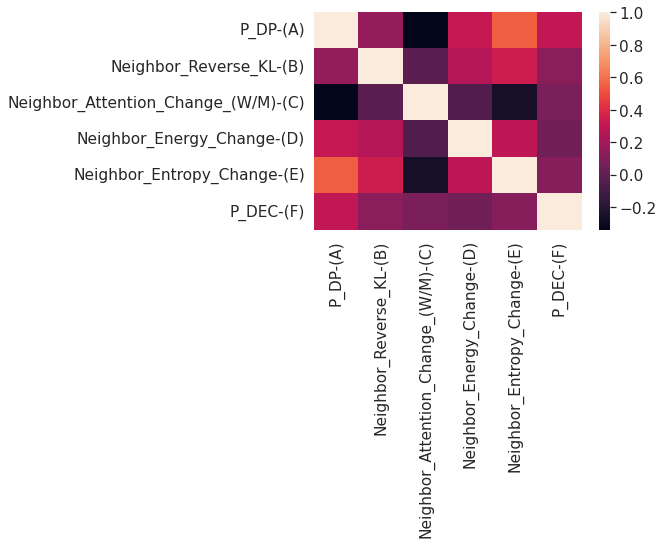

In [ ]:
# pairwise-correlation heatmaps for manuscript
import pandas as pd
import seaborn as sns

df_Ssym = pd.DataFrame(
    {'P_DP-(A)': Ssym_X[:,0],
     'Neighbor_Reverse_KL-(B)' : Ssym_X[:,4],
     'Neighbor_Attention_Change_(W/M)-(C)' : Ssym_X[:,7],
     'Neighbor_Energy_Change-(D)' : Ssym_X[:,2],
     'Neighbor_Entropy_Change-(E)' : Ssym_X[:,6],
     'P_DEC-(F)': Ssym_X[:,5], 
    })
corr = df_Ssym.corr()

sns.set(font_scale=1.4)
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

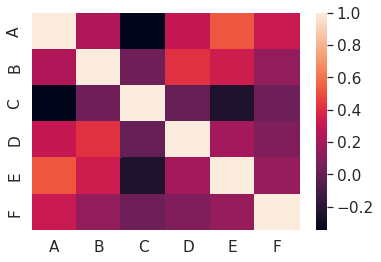

In [ ]:
# pairwise-correlation heatmaps for manuscript
import pandas as pd
import seaborn as sns

df_Ssym = pd.DataFrame(
    {'A': S_2648_X[:,0],
     'B' : S_2648_X[:,4],
     'C' : S_2648_X[:,7],
     'D' : S_2648_X[:,2],
     'E' : S_2648_X[:,6],
     'F': S_2648_X[:,5] 
    })
corr = df_Ssym.corr()

sns.set(font_scale=1.4)
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [ ]:
import pandas as pd
import seaborn as sns

df_Ssym = pd.DataFrame(
    {'P_DP': S_2648_X[:,0],
     'P_DEC': S_2648_X[:,5],
     'Neighbor_Reverse_KL' : S_2648_X[:,4],
     'Neighbor_Attention_Change_(W/M)' : S_2648_X[:,7],
     'Neighbor_Energy_Change' : S_2648_X[:,2],
     'Neighbor_Entropy_Change' : S_2648_X[:,6] 
    })
corr = df_Ssym.corr()

sns.set(font_scale=1.4)
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

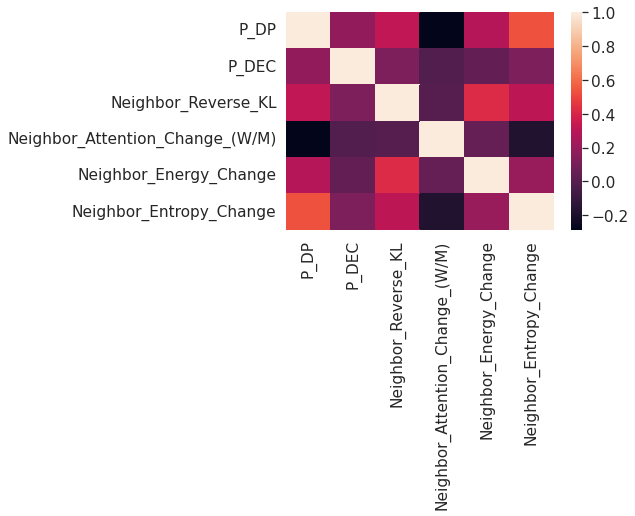

In [ ]:
# pairwise-correlation heatmaps for manuscript
import pandas as pd
import seaborn as sns

df_Ssym = pd.DataFrame(
    {'P_DP': S_669_X[:,0],
     'P_DEC': S_669_X[:,5],
     'Neighbor_Reverse_KL' : S_669_X[:,4],
     'Neighbor_Attention_Change_(W/M)' : S_669_X[:,7],
     'Neighbor_Energy_Change' : S_669_X[:,2],
     'Neighbor_Entropy_Change' : S_669_X[:,6] 
    })
corr = df_Ssym.corr()

sns.set(font_scale=1.4)
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

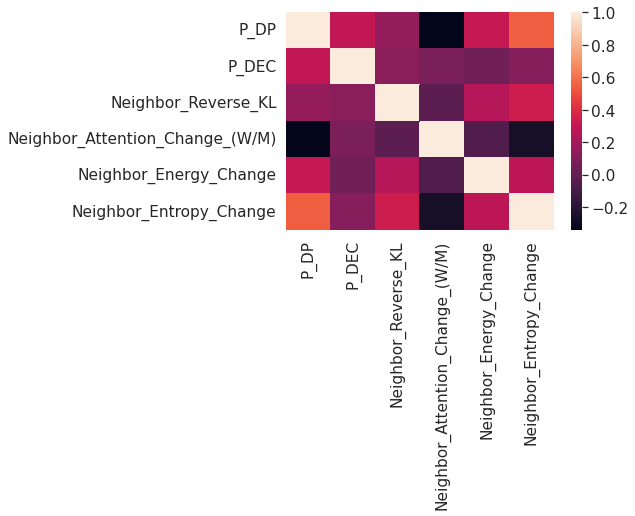

In [ ]:
# pairwise-correlation heatmaps for manuscript
import pandas as pd
import seaborn as sns

df_Ssym = pd.DataFrame(
    {'P_DP': Ssym_X[:,0],
     'P_DEC': Ssym_X[:,5],
     'Neighbor_Reverse_KL' : Ssym_X[:,4],
     'Neighbor_Attention_Change_(W/M)' : Ssym_X[:,7],
     'Neighbor_Energy_Change' : Ssym_X[:,2],
     'Neighbor_Entropy_Change' : Ssym_X[:,6] 
    })
corr = df_Ssym.corr()

sns.set(font_scale=1.4)
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

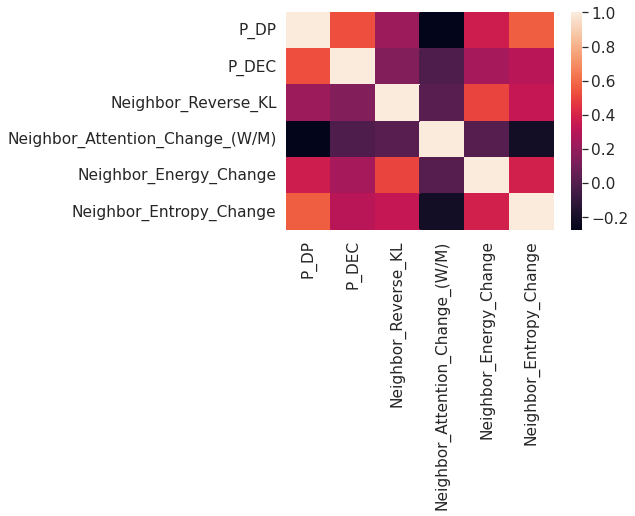

In [ ]:
# pairwise-correlation heatmaps for manuscript
import pandas as pd
import seaborn as sns

df_Ssym = pd.DataFrame(
    {'P_DP': S_921_X[:,0],
     'P_DEC': S_921_X[:,5],
     'Neighbor_Reverse_KL' : S_921_X[:,4],
     'Neighbor_Attention_Change_(W/M)' : S_921_X[:,7],
     'Neighbor_Energy_Change' : S_921_X[:,2],
     'Neighbor_Entropy_Change' : S_921_X[:,6]
    })
corr = df_Ssym.corr()

sns.set(font_scale=1.4)
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)